## Importing modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import pmdarima as pm           # brings auto_arima from R to Python

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import SimpleExpSmoothing

## Importing and splitting data

In [2]:
data = pd.read_csv(os.path.join('initial_data','BSRT Client Numbers.csv'),index_col=0,parse_dates=True)
data.head()

,1st drop,2nd drop
Date,,
2018-02-03,30,15
2018-02-24,25,9
2018-03-03,30,15
2018-02-05,30,17
2018-03-05,30,12


In [3]:
data['Count'] = data["1st drop"] + data["2nd drop"]
data.head()

,1st drop,2nd drop,Count
Date,,,
2018-02-03,30,15,45
2018-02-24,25,9,34
2018-03-03,30,15,45
2018-02-05,30,17,47
2018-03-05,30,12,42


In [4]:
train=data[0:110]
test=data[110:]

In [5]:
train.tail()

,1st drop,2nd drop,Count
Date,,,
2019-03-30,30,15,45
2019-04-01,47,14,61
2019-03-24,60,20,80
2019-04-17,34,18,52
2019-04-20,29,19,48


In [6]:
test.head()

,1st drop,2nd drop,Count
Date,,,
2019-04-27,25,20,45
2019-04-29,35,26,61
2019-05-03,25,15,40
2019-05-15,38,25,63
2019-05-17,45,25,70


## Initial plot

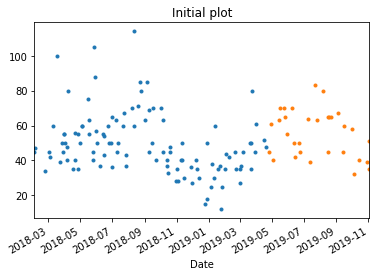

In [7]:
train["Count"].plot(style=".")
test["Count"].plot(style=".")
plt.title('Initial plot')
plt.show()

## Naive Forecast

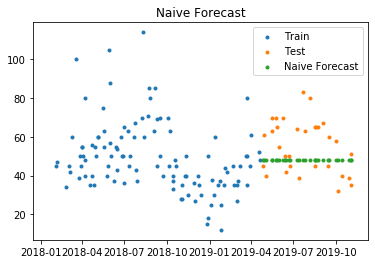

In [8]:
dd= np.asarray(train.Count)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.scatter(train.index, train.Count, marker=".",label='Train')
plt.scatter(test.index, test.Count, marker=".",label='Test')
plt.scatter(y_hat.index,y_hat['naive'], marker=".",label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [9]:
rms = sqrt(mean_squared_error(test.Count, y_hat.naive))
print(rms)

15.22942821877984


## Average Forecast

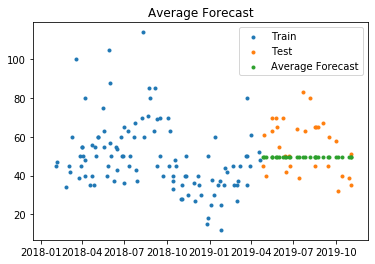

In [10]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Count'].mean()
plt.scatter(train.index, train.Count, marker=".",label='Train')
plt.scatter(test.index, test.Count, marker=".",label='Test')
plt.scatter(y_hat_avg.index,y_hat_avg['avg_forecast'], marker=".",label='Average Forecast')
plt.title("Average Forecast")
plt.legend(loc='best')
plt.show()

In [11]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.avg_forecast))
print(rms)

14.593968216051532


## Moving Average Forecast

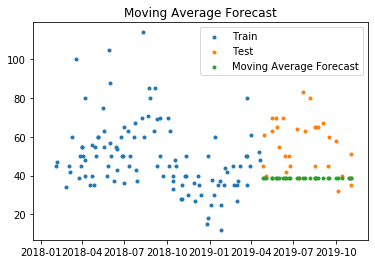

In [12]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['Count'].rolling(30).mean().iloc[-1]
plt.scatter(train.index,train['Count'], marker=".", label='Train')
plt.scatter(test.index, test['Count'], marker=".", label='Test')
plt.scatter(y_hat_avg.index, y_hat_avg['moving_avg_forecast'], marker=".", label='Moving Average Forecast')
plt.title("Moving Average Forecast")
plt.legend(loc='best')
plt.show()

In [13]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.moving_avg_forecast))
print(rms)

21.289366656067703


## Simple Exponential Smoothing

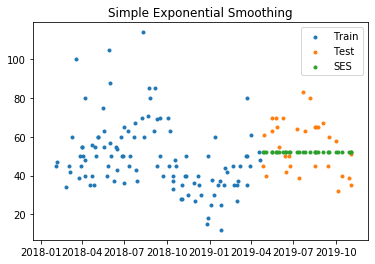

In [14]:
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test))

plt.scatter(train.index,train['Count'], marker='.', label='Train')
plt.scatter(test.index,test['Count'], marker='.',label='Test')
plt.scatter(y_hat_avg.index,y_hat_avg['SES'], marker='.',label='SES')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing')
plt.show()

In [15]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.SES))
print(rms)

13.594964499935655


## ARIMA
### Lag plots

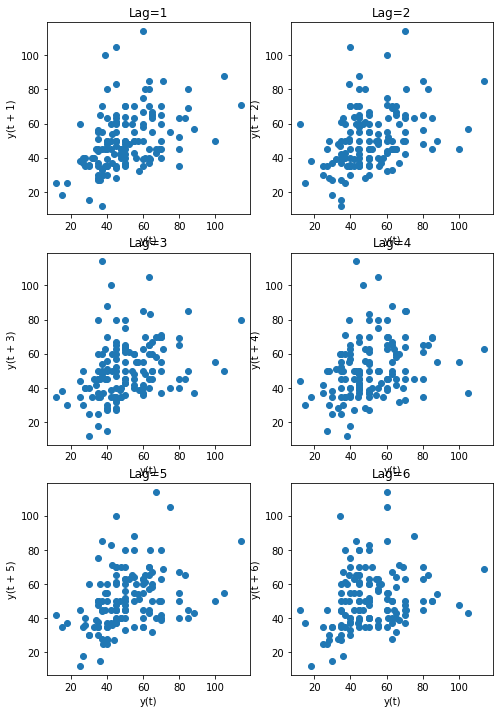

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(8, 12))
plt.title('MSFT Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    pd.plotting.lag_plot(data['Count'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

plt.show()

### Finding differencing term

In [17]:
kpss_diffs = pm.arima.ndiffs(train.Count, alpha=0.05, test='kpss', max_d=6)
adf_diffs = pm.arima.ndiffs(train.Count, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
# Estimated differencing term: 1

Estimated differencing term: 1


### Fitting model to data

In [18]:
auto = pm.auto_arima(train.Count, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Fit ARIMA: order=(2, 1, 2); AIC=919.320, BIC=935.468, Fit time=0.249 seconds
Fit ARIMA: order=(0, 1, 0); AIC=955.487, BIC=960.870, Fit time=0.007 seconds
Fit ARIMA: order=(1, 1, 0); AIC=933.021, BIC=941.095, Fit time=0.035 seconds
Fit ARIMA: order=(0, 1, 1); AIC=913.692, BIC=921.766, Fit time=0.034 seconds
Fit ARIMA: order=(1, 1, 1); AIC=915.366, BIC=926.132, Fit time=0.068 seconds
Fit ARIMA: order=(0, 1, 2); AIC=915.376, BIC=926.141, Fit time=0.058 seconds
Fit ARIMA: order=(1, 1, 2); AIC=917.260, BIC=930.717, Fit time=0.152 seconds
Total fit time: 0.606 seconds


In [19]:
auto.order

(0, 1, 1)

### Obtaining predictions

In [20]:
model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test.Count:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)
    model.update(new_ob)

### Plotting scatter graph

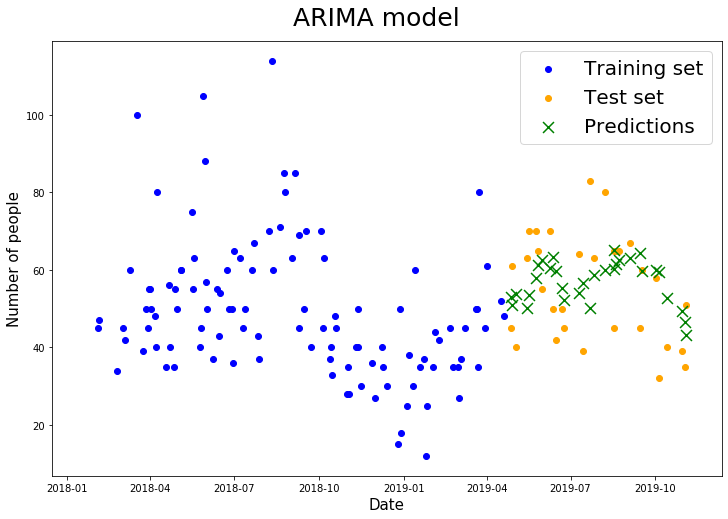

In [21]:
plt.figure(figsize=(12, 8))
plt.scatter(train.index, train.Count, color='blue',label='Training set')
plt.scatter(test.index, test.Count, color='orange',label='Test set')
plt.scatter(test.index, forecasts, color='green',label='Predictions',marker='x',s=120)
plt.suptitle('ARIMA model', x=.5, y=0.94, fontsize=25)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of people', fontsize=15)
plt.legend(prop={'size': 20})
plt.savefig('arima_scatter.png')
plt.show()

In [22]:
rms = sqrt(mean_squared_error(test.Count, forecasts))
print(rms)

13.48568679450992


### Plotting scatter graph with confidence intervals

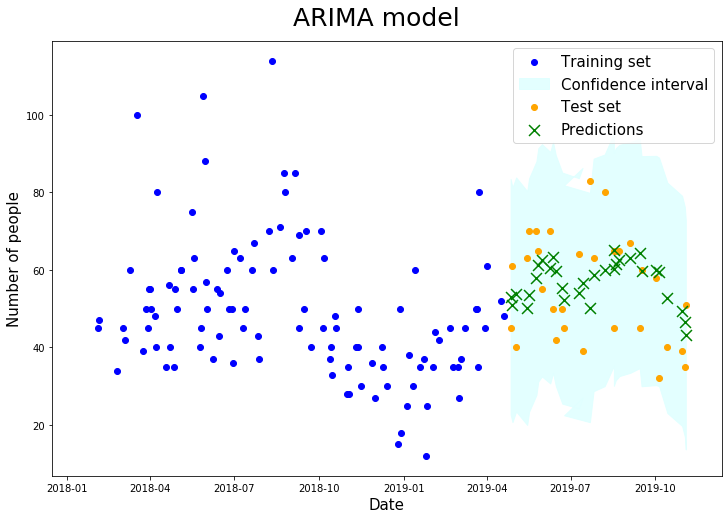

In [23]:
plt.figure(figsize=(12, 8))

plt.scatter(train.index, train.Count, color='blue',label='Training set')

conf_int = np.asarray(confidence_intervals)
plt.fill_between(test.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='lightcyan',
                     label="Confidence interval")

plt.scatter(test.index, test.Count, color='orange',label='Test set')
plt.scatter(test.index, forecasts, color='green',label='Predictions',marker='x',s=120)
plt.suptitle('ARIMA model', x=.5, y=0.94, fontsize=25)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of people', fontsize=15)
plt.legend(prop={'size': 15})
plt.show()